# Leigh Ann Kudloff and Nataly Valenzuela Mullen 
# Final Project--Data Science Tools 1  
# Winter 2021

## I.	Introduction/Story
### Like most Data Science students, concern about job opportunities in the near future loom heavily at the halfway point of this degree program.  In one year, employment is necessary to pay off student loans and enter the world of data science.  This project focuses on the world of job hunting in Data Science.  The goal is to explore job descriptions to categorize skill sets, look for patterns, and prepare tools for the job hunt later this year.  Through the exploration of trends in data science job postings, the concepts learned from Data Science Tools 1 and other classes will be applied and hopefully the ideal jobs will emerge.

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pandas_profiling  as pp
import plotly.express    as px
import re

from mpl_toolkits.mplot3d    import Axes3D
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance  import pdist
from sklearn                 import datasets
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA
from sklearn.metrics         import confusion_matrix

import string
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer

In [2]:
df1 = pd.read_csv("DataScienceJobs.csv")

df1 = df1[["Job Title", "Job Description", "Company Name", "City", "State", "Size", 
           "Years_Founded", "Industry", "Rating", "Min_Salary", "Max_Salary", "Est_Salary"]]

strCols = df1.select_dtypes(['object']).columns
df1[strCols] = df1[strCols].apply(lambda x: x.str.strip())

# Used this code to adjust UK jobs for US:  
                                            #df1[df1.State.isin(["United Kingdom"])]
                                            #df1.iloc[1870]["Job Description"]
df1.iloc[1637,3]="Upper Providence"
df1.iloc[1784,3]="Upper Providence"
df1.iloc[1799,3]="Upper Providence"
df1.iloc[1870,3]="Philadelphia"
df1.iloc[[1637, 1784, 1799, 1870], 4]="PA"

# Create Location by joining columns--City and State
df1["Location"]=df1["City"] +", " + df1["State"]

# Creating a column for Remote work
df1.loc[df1["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df1["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1_to_50_employees": "Very Small", 
           "51_to_200_employees": "Small",
          "201_to_500_employees": "Medium-Small",
          "501_to_1000_employees": "Medium",
          "1001_to_5000_employees": "Medium-Large",
          "5001_to_10000_employees": "Large",
          "10000_employees": "Very Large"}
df1["Size"].replace(sizeKey, inplace=True)

df1.rename({"Min_Salary": "SalaryMin", "Max_Salary": "SalaryMax", "Est_Salary": "Salary Estimate"}, 
                  axis=1, inplace=True)

#Changing Years_Founded to Founded
df1["Founded"]=2020-df1["Years_Founded"]
df1.drop(["Years_Founded"], axis=1, inplace=True)

# Removing underscores from Industry
df1["Industry"]=df1["Industry"].replace("_", " ", regex=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF1=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF1duplicates=df1[df1.duplicated(criteriaDF1)].sort_values(by=criteriaDF1)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df1=df1[~df1.duplicated(criteriaDF1)]

# Dataframe Label
df1["DF"]= "DF1"

# Reordered Columns for Readability
df1 = df1.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote", 
                                             "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df1.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

print(DF1duplicates.shape)
print(df1.shape)
#df1.head(10)
#df1.State.value_counts()
list(df1.Size.unique())
df1.sample(10)

(21, 14)
(12339, 15)


Job Title  \
7099                      Software Engineer   
10349                  Jr. Business Analyst   
3914   Data + Business Intelligence Analyst   
8032                          Data Engineer   
5646          + Global Process Data Analyst   
4985      Healthcare Data Analytics Analyst   
9810                   Business Analyst III   
3648                          Data Engineer   
7600             Staff Reliability Engineer   
10006                       Systems Analyst   

                                         Job Description  \
7099   Role .NET Software Engineer Location Phoenix, ...   
10349  Job Description\nEndeavor Consulting Group, LL...   
3914   We are building Duolingo's newly formed FP&A /...   
8032   Hello,\nÂ\nPosition:ÂData EngineerÂ\nLocation:...   
5646   Duration & Type: 6+ months Contract with a Pha...   
4985   Healthcare Data Analytics Analyst\nLocation\n\...   
9810   Ignite is currently recruiting for a part-time...   
3648   The Data Engineer joins a team of engineers, s...   
7600   Job Description Summary\nJob Description\n\n\n...   
10006  Description\nDo you want your voice heard and ...   

                           Company Name          Location          City State  \
7099     Atrilogy Solutions Group, Inc.       Phoenix, AZ       Phoenix    AZ   
10349  International Consulting Company  Philadelphia, PA  Philadelphia    PA   
3914                           Duolingo      New York, NY      New York    NY   
8032            Conch Technologies, Inc      San Jose, CA      San Jose    CA   
5646         InfoQuest Consulting Group    Fort Worth, TX    Fort Worth    TX   
4985                AmeriHealth Caritas  Philadelphia, PA  Philadelphia    PA   
9810                             Ignite       Houston, TX       Houston    TX   
3648                        NT Concepts    Fort Worth, TX    Fort Worth    TX   
7600                                 BD     San Diego, CA     San Diego    CA   
10006                              MUFG         Tempe, AZ         Tempe    AZ   

          Remote          Size  Founded                            Industry  \
7099   Uncertain         Small   2000.0                         IT Services   
10349  Uncertain         Large      NaN                          Consulting   
3914   Uncertain  Medium-Small   2011.0                            Internet   
8032   Uncertain         Small      NaN                          Consulting   
5646   Uncertain    Very Small      NaN          Computer Hardware Software   
4985   Uncertain         Large   1983.0                  Insurance Carriers   
9810   Uncertain         Small      NaN          Computer Hardware Software   
3648   Uncertain        Medium   1998.0                         IT Services   
7600   Uncertain    Very Large   1897.0  Health Care Products Manufacturing   
10006  Uncertain    Very Large   1864.0                 Banks Credit Unions   

       Rating  SalaryMin  SalaryMax  Salary Estimate   DF  
7099      4.9         74        145            109.5  DF1  
10349     4.0         41         88             64.5  DF1  
3914      5.0         37         66             51.5  DF1  
8032      4.6        108        199            153.5  DF1  
5646      4.7         57         70             63.5  DF1  
4985      3.1         38         68             53.0  DF1  
9810      3.0         53         96             74.5  DF1  
3648      3.3         47         84             65.5  DF1  
7600      3.6        113        198            155.5  DF1  
10006     3.1         51         99             75.0  DF1

In [3]:
df2 = pd.read_csv("DataScientist.csv")

df2 = df2[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = df2.select_dtypes(['object']).columns
df2[strCols] = df2[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# df2[df2.State.isin(["United Kingdom"])]
#print(df2.State.value_counts())
#print(df2[df2.State.isin([" United Kingdom"])])

df2.iloc[1647,3]="Upper Providence, PA"
df2.iloc[1794,3]="Upper Providence, PA"
df2.iloc[1809,3]="Upper Providence, PA"
df2.iloc[1880,3]="Philadelphia, PA"

# Split Location into new columns--City and State
df2[["City", "State"]]= df2["Location"].str.split(",", n = 1, expand = True)
df2.loc[(~df2["Location"].str.contains(",")), "State"]=df2.loc[(~df2["Location"].str.contains(",")),"City"]
df2["State"]=df2["State"].str.strip()
df2.loc[(~df2["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
df2.loc[(df2["Location"]=="Remote"), "Remote"]="Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
df2.loc[(df2["Location"]=="Remote"), "State"]=np.nan

# Creating a column for Remote work
df2.loc[df2["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
df2["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
df2[["SalaryTest", "Salary"]] = df2["Salary Estimate"].str.split("(", n = 1, expand = True)
df2[["SalaryMin", "SalaryMax"]]= df2["SalaryTest"].str.split("-", n = 1, expand = True)
df2.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
df2["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
df2["SalaryMin"]=df2["SalaryMin"].replace("[$K]","",regex=True)
df2["SalaryMax"]=df2["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
df2["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
df2[["Company Name", "RateTest"]] = df2["Company Name"].str.split("\n", n=1, expand = True)
df2.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDF2=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DF2duplicates=df2[df2.duplicated(criteriaDF2)].sort_values(by=criteriaDF2)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
df2=df2[~df2.duplicated(criteriaDF2)]

# Dataframe Label
df2["DF"]= "DF2"

# Reordered Columns for Readability
df2 = df2.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", "Remote",
                              "Size", "Founded", "Industry", "Rating", "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
df2.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
#df2["Founded"]=df2["Founded"].astype(int)--We found this did not work well.

#print(DF2duplicates.shape)
print(df2.shape)
df2.sample(10)

(3909, 15)


Job Title  \
1351  Internship - Analytics and Data Science (Healt...   
3633                       Senior Data Engineer - C3.ai   
1899  Pharmaceutical Upstream Processing Scientist -...   
2754  Performance Assurance Engineer (Data Science B...   
3821               Consultant, Telematics Data Engineer   
791                             Quantitative Researcher   
2914                Part-Time Instructor (Data Science)   
772                                      Data Scientist   
3162                                      Data Engineer   
2894                                     Data Scientist   

                                        Job Description  \
1351  Blue Cross Blue Shield of Arizona is a local, ...   
3633  Position Title: Senior Data Engineer - C3.ai\n...   
1899  Job Description\n*1 year contract position wit...   
2754  GTA is a leading independent provider of high-...   
3821  As a team member in the Finance and Internal A...   
791   DRW is a technology-driven, diversified princi...   
2914  Job Description :\nWe are looking for part-tim...   
772   Careers | UL | Data Scientist in Northbrook, I...   
3162  Position Senior Data Engineer Location Menlo P...   
2894  Job Description\nRole: Data Scientist.\nLocati...   

                           Company Name          Location          City State  \
1351  Blue Cross Blue Shield of Arizona       Phoenix, AZ       Phoenix    AZ   
3633                           Skiltrek  Jacksonville, FL  Jacksonville    FL   
1899                 On-Board Companies    West Point, PA    West Point    PA   
2754       Global Technology Associates        Dallas, TX        Dallas    TX   
3821                         Nationwide      Columbus, OH      Columbus    OH   
791                   DRW Trading Group       Chicago, IL       Chicago    IL   
2914                           BitTiger   Santa Clara, CA   Santa Clara    CA   
772           Underwriters Laboratories    Northbrook, IL    Northbrook    IL   
3162                           Indrasol    Menlo Park, CA    Menlo Park    CA   
2894                        Centraprise  Redwood City, CA  Redwood City    CA   

         Remote          Size  Founded                               Industry  \
1351  Uncertain  Medium-Large   1939.0                     Insurance Carriers   
3633  Uncertain         Small      NaN                                    NaN   
1899  Uncertain  Medium-Large   1976.0                             Consulting   
2754  Uncertain  Medium-Small      NaN                            IT Services   
3821  Uncertain    Very Large   1925.0                                    NaN   
791   Uncertain  Medium-Large   1992.0  Investment Banking & Asset Management   
2914  Uncertain    Very Small   2016.0            Education Training Services   
772   Uncertain    Very Large   1894.0                             Consulting   
3162  Uncertain    Very Small      NaN                                    NaN   
2894  Uncertain         Small      NaN                            IT Services   

      Rating SalaryMin SalaryMax  Salary Estimate   DF  
1351     3.1        97      159               NaN  DF2  
3633     NaN        66      130               NaN  DF2  
1899     3.4        68       89               NaN  DF2  
2754     3.8        48       89               NaN  DF2  
3821     3.6        52       94               NaN  DF2  
791      3.9        31       56               NaN  DF2  
2914     4.3       111      175               NaN  DF2  
772      3.3        91      105               NaN  DF2  
3162     5.0       141      225               NaN  DF2  
2894     4.2       111      175               NaN  DF2

In [4]:
# column selection--unnecessary columns eliminated
dfGlassdoor = pd.read_csv("glassdoor_jobs.csv")
# print(list(dfGlassdoor.columns))
dfGlassdoor.drop(['Headquarters', 'Sector', 'Revenue', 'Competitors', 'Type of ownership'],axis = 1, inplace = True)

strCols = dfGlassdoor.select_dtypes(['object']).columns
dfGlassdoor[strCols] = dfGlassdoor[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations:  
# dfGlassdoor[dfGlassdoor.State.isin (["None", " Raleigh", " Anne Arundel, MD"])])

dfGlassdoor.iloc[297,5]="Patuxent, MD"
dfGlassdoor.iloc[136,5]="Raleigh, NC"
dfGlassdoor.iloc[320,5]="Remote"
dfGlassdoor.iloc[12,5]="Portland, OR"
dfGlassdoor.iloc[157,5]="Chicago, IL"
dfGlassdoor.iloc[163,5]="Pembroke Pines, Florida"
dfGlassdoor.iloc[11,5]="Holmdel, NJ"
dfGlassdoor.iloc[346,5]="Middlesex, NJ"
dfGlassdoor.iloc[757,5]="Arlington, VA"
dfGlassdoor.iloc[758,5]="Hollywood, CA"
dfGlassdoor.iloc[830,5]="Washington, DC"

# Split Location into new columns--City and State and make city nan
dfGlassdoor[["City", "State"]]= dfGlassdoor["Location"].str.split(",", n = 1, expand = True)
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "State"]=dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")),"City"]
dfGlassdoor["State"]=dfGlassdoor["State"].str.strip()
dfGlassdoor.loc[(~dfGlassdoor["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "Remote"]="Yes"
dfGlassdoor["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfGlassdoor.loc[(dfGlassdoor["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfGlassdoor.loc[dfGlassdoor["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfGlassdoor[["SalaryTest", "Salary"]] = dfGlassdoor["Salary Estimate"].str.split("(", n = 1, expand = True)
dfGlassdoor[["SalaryMin", "SalaryMax"]]= dfGlassdoor["SalaryTest"].str.split("-", n = 1, expand = True)
dfGlassdoor.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfGlassdoor["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfGlassdoor["SalaryMin"]=dfGlassdoor["SalaryMin"].replace("[$K]","",regex=True)
dfGlassdoor["SalaryMax"]=dfGlassdoor["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfGlassdoor["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfGlassdoor[["Company Name", "RateTest"]] = dfGlassdoor["Company Name"].str.split("\n", n=1, expand = True)
dfGlassdoor.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaGD=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#GDduplicates=dfGlassdoor[dfGlassdoor.duplicated(criteriaGD)].sort_values(by=criteriaGD)
#testGD=GDduplicates.loc[GDduplicates["SalaryMin"].notnull()]
dfGlassdoor=dfGlassdoor[~dfGlassdoor.duplicated(criteriaGD)]

# Dataframe Label
dfGlassdoor["DF"]= "GD"

# Reordered Columns for Readability
dfGlassdoor = dfGlassdoor.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfGlassdoor.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfGlassdoor.fillna(value=np.nan, axis=1, inplace=True)
#dfGlassdoor["Founded"]=dfGlassdoor["Founded"].astype(int)--We found this did not work well.

#print(testGD.shape)
print(dfGlassdoor.shape)
dfGlassdoor.sample(20)


(899, 15)


Job Title  \
221           Epidemiology Research Data Specialist II   
185              Program/Data Analyst, Mid-level - FAA   
665                                     Data Scientist   
189                           Data Engineering Manager   
786                             Data Scientist, Senior   
81            Scientist - Biomarker and Flow Cytometry   
703                                     Data Scientist   
240          Principal Scientist, Analytical Chemistry   
47                Diversity and Inclusion Data Analyst   
145                                       Data Analyst   
664                    Development Scientist, Theraflu   
6                                 Senior Data Engineer   
732                                     Data Scientist   
430                                Senior Data Modeler   
562                                     Data Scientist   
134  Director Data Scientist: Causal & Predictive a...   
432                                     Data Scientist   
471                                     Data Scientist   
793                                     Data Scientist   
897                                     Data Scientist   

                                       Job Description  \
221  At St. Jude Childrens Research Hospital we col...   
185  Position: Program/Data Analyst, Mid-level - FA...   
665  Job Description\nStrategic ACI is seeking a Da...   
189  At American Family Insurance, we’re driven by ...   
786  Join our team dedicated to developing and exec...   
81   Crown Bioscience, a JSR Life Sciences company,...   
703  Role: Channel Analytics - Data Scientist\n\nDu...   
240  Who We Are:\n\n\nAt Neurocrine Biosciences, we...   
47   Position Summary\n\n\nThe D&I Data Analyst wil...   
145  Beazley is seeking a Data Analyst to develop a...   
664  Site Name: Richmond Sherwood\nPosted Date: Apr...   
6    Senior Data Engineer\nLocation/City: Atlanta, ...   
732  About Datadog:\n\nWe're on a mission to build ...   
430  We're looking for an innovative Data Modeler t...   
562  Avenue Code is an eCommerce consulting firm he...   
134  21-Jan-2020\n\nJob ID\n279463BR\n{"QuestionNam...   
432  Role Data Scientist, Business analytics and Re...   
471  Â\n\nRole: Data scientist\n\nLocation: Keene, ...   
793  ** Elutions will be unable to sponsor or trans...   
897  Job Description\nThe Data Scientist\n\nThis in...   

                              Company Name           Location           City  \
221  St. Jude Children's Research Hospital        Memphis, TN        Memphis   
185                       Cobec Consulting        Jamaica, NY        Jamaica   
665     Strategic Alliance Consulting, Inc    Springfield, VA    Springfield   
189              American Family Insurance        Chicago, IL        Chicago   
786                                Novetta   Fort Belvoir, VA   Fort Belvoir   
81                        Crown Bioscience      San Diego, CA      San Diego   
703                      Bayside Solutions      Sunnyvale, CA      Sunnyvale   
240                 Neurocrine Biosciences      San Diego, CA      San Diego   
47                      FHLBank Pittsburgh     Pittsburgh, PA     Pittsburgh   
145                          Beazley Group   Philadelphia, PA   Philadelphia   
664                                    GSK       Richmond, VA       Richmond   
6                                   Steady        Atlanta, GA        Atlanta   
732                                Datadog       New York, NY       New York   
430        First Tech Federal Credit Union        Rocklin, CA        Rocklin   
562                         avenuecode.com  San Francisco, CA  San Francisco   
134                               Novartis      Cambridge, MA      Cambridge   
432                     RM Technotree Inc.       Buckhead, GA       Buckhead   
471                    Kairos Technologies          Keene, NH          Keene   
793                           Apex Systems     Chesapeake, VA     Chesapeake   
897    

In [5]:
dfIndeed = pd.read_csv("df_all_indeed.csv")

dfIndeed.drop(['Unnamed: 0','Easy_Apply'],axis = 1, inplace = True)

strCols = dfIndeed.select_dtypes(['object']).columns
dfIndeed[strCols] = dfIndeed[strCols].apply(lambda x: x.str.strip())

dfIndeed.iloc[[57, 114, 231,3521,3632,3637,3961],2]="Carlsbad, NM"
dfIndeed.iloc[[3520, 3578, 3661,3666,3776, 3843, 3967],2]="Spring, TX"
dfIndeed.iloc[3772, 2]="Panama City, FL"
dfIndeed.iloc[[1607, 1765, 1801],2]="New York, NY"
dfIndeed.iloc[[557, 665],2]="Remote"
dfIndeed.iloc[[410,1484],2]="San Diego, CA"
dfIndeed.iloc[418, 2]="Los Angelos, CA"
dfIndeed.iloc[82, 2]="Denver, CO"
dfIndeed.iloc[[1009, 1327],2]="Menlo Park, CA"

dfIndeed[["City", "State"]]= dfIndeed["Locations"].str.split(",", n = 1, expand = True)
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "State"]=dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")),"City"]
dfIndeed.loc[(~dfIndeed["Locations"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "Remote"]="Yes"
dfIndeed["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfIndeed.loc[(dfIndeed["Locations"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfIndeed.loc[(dfIndeed["Summary"].str.contains("Remote|remote")==True), "Remote"]= "Yes"
dfIndeed.loc[(dfIndeed["Jobs"].str.contains("Remote|remote")==True), "Remote"]= "Yes"

dfIndeed.rename({"Summary": "Job Description", "Companies": "Company Name", "Jobs": "Job Title", "Locations": "Location"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaIN=["Company Name", "Job Title", "City", "State", "Job Description"]
INduplicates=dfIndeed[dfIndeed.duplicated(criteriaIN)].sort_values(by=criteriaIN)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfIndeed=dfIndeed[~dfIndeed.duplicated(criteriaIN)]

# Dataframe Label
dfIndeed["DF"]= "IN"

# Reordered Columns for Readability
dfIndeed = dfIndeed.reindex(columns = ["Job Title", "Job Description", "Company Name", 
                                       "Location", "City", "State", "Remote", "Rating", "DF"])
#print(INduplicates.shape)
print(dfIndeed.shape)
dfIndeed.head(10)

(2871, 9)


Job Title  \
0                               Data Science Modeler   
1                   Director Integrated Data Science   
2                                     Data Scientist   
3                                     Data Scientist   
4               Sr Business Analyst / Data Scientist   
5                                      Data Engineer   
6                                     Data Scientist   
7                                     Data Scientist   
8                               Data Science Analyst   
9  Senior Applications Scientist, Bioinformatics/...   

                                     Job Description          Company Name  \
0  As a Data Science Modeler, you will be a key p...                 Avero   
1  Demonstrated knowledge of programming expertis...                  UPMC   
2  University bachelor’s degree in data science, ...  Willis Towers Watson   
3  Effectively represent the Data Science group i...       Valen Analytics   
4  See the data “forest for the trees” and help i...               PHOENIX   
5  Troubleshoot basic data and data engineering i...       Valen Analytics   
6  Data scientists use data and analytical abilit...            Horizontal   
7  Data Science: 3 years (Preferred). Data scient...             Pricesenz   
8  Data Engineer Tech – :Cleaning and Integrating...   xentity corporation   
9  Expertise in probability & statistics, machine...             Inscripta   

         Location        City State     Remote  Rating  DF  
0     Boulder, CO     Boulder    CO  Uncertain     2.6  IN  
1    Loveland, CO    Loveland    CO  Uncertain     3.7  IN  
2      Denver, CO      Denver    CO  Uncertain     3.7  IN  
3      Denver, CO      Denver    CO  Uncertain     NaN  IN  
4      Denver, CO      Denver    CO  Uncertain     NaN  IN  
5      Denver, CO      Denver    CO  Uncertain     NaN  IN  
6  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
7  Broomfield, CO  Broomfield    CO  Uncertain     NaN  IN  
8      Denver, CO      Denver    CO  Uncertain     4.6  IN  
9     Boulder, CO     Boulder    CO  Uncertain     3.0  IN

In [6]:
dfLinkedIn = pd.read_csv("df_all_linkedin.csv")

dfLinkedIn.drop(['Unnamed: 0','Number_of_Applicants', 'Length_of_Description', 'num_applicants'],axis = 1, inplace = True)

#This strips unnecessary white spaces.
strCols = dfLinkedIn.select_dtypes(['object']).columns
dfLinkedIn[strCols] = dfLinkedIn[strCols].apply(lambda x: x.str.strip())

#This code was used to clean up city names and areas.
#for i, s in enumerate(dfLinkedIn['Location']):
#    if not s.endswith(', US') and not s.endswith(', United States'):
#        print(i, s)

cities = {'Greater Denver Area':              'Denver',
          'San Francisco Bay Area':           'San Francisco',
          'Greater Los Angeles Area':         'Los Angeles',
          'Greater New York City Area':       'New York City',
          'New York City Metropolitan Area':  'New York City',
          'Greater Seattle Area':             'Seattle',
          'Salt Lake City Metropolitan Area': 'Salt Lake City',
          'Miami/Fort Lauderdale Area':       'Miami'}

# Separates the location into City column and throws away the state and US info
dfLinkedIn[["City", "Temp"]] = dfLinkedIn["Location"].str.split(",", 1, expand = True)
dfLinkedIn.drop("Temp", axis = 1, inplace = True)
dfLinkedIn["City"].replace(cities, inplace=True)
dfLinkedIn["Location"]=dfLinkedIn["City"]+", "+ dfLinkedIn["State"]

# Adding to column for Remote work from Job Description
dfLinkedIn.loc[dfLinkedIn["Description"].str.contains("Remote|remote"), "Remote"]= "Yes"
dfLinkedIn["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)

dfLinkedIn.rename({"Description": "Job Description", "Company": "Company Name", "Job_Title": "Job Title"}, 
                  axis=1, inplace=True)

# Remove duplicate Job listing with same Job Descriptions
criteriaLI=["Company Name", "Job Title", "City", "State", "Junior", "Senior", "Job Description"]
LIduplicates=dfLinkedIn[dfLinkedIn.duplicated(criteriaLI)].sort_values(by=criteriaLI)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfLinkedIn=dfLinkedIn[~dfLinkedIn.duplicated(criteriaLI)]

# Dataframe Label
dfLinkedIn["DF"]= "LI"

# Reordered Columns for Readability
dfLinkedIn = dfLinkedIn.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Junior", "Senior", "DF"])
#print(LIduplicates.shape)
#print(dfLinkedIn.head())
print(dfLinkedIn.shape)
dfLinkedIn.head(10)

(1356, 10)


Job Title  \
0                         Data Acquisition Developer   
1                             DATA SCIENTIST MANAGER   
2  Data Scientist – Logistics Optimization Algori...   
3  Senior Director - Global Data & Analytics Arch...   
4  Senior Consultant - Professional Services (Rem...   
5                                     Data Scientist   
6                     Data Scientist I - 2020 Campus   
7                                      Data Engineer   
8                                      Data Engineer   
9                          Marketing Science Analyst   

                                     Job Description            Company Name  \
0  Join ABB and work in a team that is dedicated ...                     ABB   
1  Pilgrim’s is the second largest chicken produc...               Pilgrim's   
2  Location: Denver, CO – Relocation Offered. Rem...               ShaleApps   
3  VF Corporation outfits consumers around the wo...          VF Corporation   
4  Who We AreTalend is a leader in cloud data int...                  Talend   
5  Job FamilyAdvanced AnalyticsJob Description Su...  Aegon Asset Management   
6  This is a talent pipeline requisition for coll...              Travelport   
7  Job Description Apply proven expertise and bui...           Fahrenheit IT   
8  Data Engineer – Denver, Colorado Want to work ...           Western Union   
9  OverviewAnalytic Partners is looking for a Mar...       Analytic Partners   

         Location        City State     Remote  Junior  Senior  DF  
0  Broomfield, CO  Broomfield    CO  Uncertain       0       0  LI  
1     Greeley, CO     Greeley    CO  Uncertain       0       0  LI  
2      Denver, CO      Denver    CO        Yes       0       0  LI  
3      Denver, CO      Denver    CO        Yes       0       1  LI  
4      Denver, CO      Denver    CO  Uncertain       0       1  LI  
5      Denver, CO      Denver    CO  Uncertain       0       0  LI  
6   Englewood, CO   Englewood    CO  Uncertain       0       0  LI  
7      Denver, CO      Denver    CO  Uncertain       0       0  LI  
8      Denver, CO      Denver    CO  Uncertain       0       0  LI  
9      Denver, CO      Denver    CO  Uncertain       0       0  LI

In [7]:
dfDataAnalyst = pd.read_csv("DataAnalyst.csv")

dfDataAnalyst = dfDataAnalyst[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataAnalyst.select_dtypes(['object']).columns
dfDataAnalyst[strCols] = dfDataAnalyst[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataAnalyst[["City", "State"]]= dfDataAnalyst["Location"].str.split(",", n = 1, expand = True)
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "State"]=dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")),"City"]
dfDataAnalyst["State"]=dfDataAnalyst["State"].str.strip()
dfDataAnalyst.loc[(~dfDataAnalyst["Location"].str.contains(",")), "City"]=np.nan

#dfDataAnalyst=dfDataAnalyst.loc[(dfDataAnalyst["State"]=="Arapahoe, CO")]
dfDataAnalyst.loc[(dfDataAnalyst["State"].str.contains("Arapahoe, CO")),"State"]="CO"

# Creating a column for Remote work and make state nan
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "Remote"]="Yes"
dfDataAnalyst["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataAnalyst.loc[(dfDataAnalyst["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataAnalyst.loc[dfDataAnalyst["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataAnalyst[["SalaryTest", "Salary"]] = dfDataAnalyst["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataAnalyst[["SalaryMin", "SalaryMax"]]= dfDataAnalyst["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataAnalyst.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataAnalyst["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataAnalyst["SalaryMin"]=dfDataAnalyst["SalaryMin"].replace("[$K]","",regex=True)
dfDataAnalyst["SalaryMax"]=dfDataAnalyst["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataAnalyst["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataAnalyst[["Company Name", "RateTest"]] = dfDataAnalyst["Company Name"].str.split("\n", n=1, expand = True)
dfDataAnalyst.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDA=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DAduplicates=dfDataAnalyst[dfDataAnalyst.duplicated(criteriaDA)].sort_values(by=criteriaDA)
#testDA=DAduplicates.loc[DAduplicates["SalaryMin"].notnull()]
dfDataAnalyst=dfDataAnalyst[~dfDataAnalyst.duplicated(criteriaDA)]

# Dataframe Label
dfDataAnalyst["DF"]= "DA"

# Reordered Columns for Readability
dfDataAnalyst = dfDataAnalyst.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataAnalyst.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataAnalyst.fillna(value=np.nan, axis=1, inplace=True)

#print(testDA.shape)
print(dfDataAnalyst.shape)
dfDataAnalyst.sample(10)

(2253, 15)


Job Title  \
1720    DPS - FIN - CAPPS Financial Senior Data Analyst   
2033  Senior Business Technology Analyst - MDM / Dat...   
1503                              Business Data Analyst   
1709  Leading Data-Driven Change -- Data Industry An...   
190                             Data Management Analyst   
546                                        Data Analyst   
770                     Provider Analytics Data Analyst   
379                          QA Production Data Analyst   
1273                                   Data Analyst III   
1074                         Data Analyst - Entry Level   

                                        Job Description  \
1720  DPS - FIN - CAPPS Financial Senior Data Analys...   
2033  ZS is a professional services firm that works ...   
1503  Company Description\n\nnull\nJob Description\n...   
1709  Lots of people talk about "making the world a ...   
190   TSR is a premier National U.S. Staffing compan...   
546   Data Analyst Location Glendale, CA Duration 3 ...   
770   Job Description\nProvider Analytics Data Analy...   
379   QA Production Data Analyst\n\n\nJob Ref: 53295...   
1273  Potomac Management Solutions is looking for a ...   
1074  Looking to hire for a Data Analyst role with o...   

                           Company Name             Location             City  \
1720  TEXAS DEPARTMENT OF PUBLIC SAFETY           Austin, TX           Austin   
2033                      ZS Associates    San Francisco, CA    San Francisco   
1503               Infotree Service Inc         San Jose, CA         San Jose   
1709                           GasPedal           Austin, TX           Austin   
190                      TSR Consulting         New York, NY         New York   
546                         iSpace, Inc         Glendale, CA         Glendale   
770                           CRS Group          Chicago, IL          Chicago   
379               Metroplus Health Plan         New York, NY         New York   
1273                 Potomac Management        San Diego, CA        San Diego   
1074      2000 east westmoreland st llc  King of Prussia, PA  King of Prussia   

     State     Remote          Size  Founded  \
1720    TX  Uncertain  Medium-Large      NaN   
2033    CA  Uncertain         Large   1983.0   
1503    CA  Uncertain         Small   2004.0   
1709    TX        Yes    Very Small   2007.0   
190     NY  Uncertain  Medium-Small   1969.0   
546     CA  Uncertain         Small   2000.0   
770     IL  Uncertain         Small   1994.0   
379     NY  Uncertain  Medium-Large   1985.0   
1273    CA  Uncertain         Small      NaN   
1074    PA  Uncertain           NaN      NaN   

                              Industry  Rating SalaryMin SalaryMax  \
1720             Municipal Governments     3.4        43       77    
2033                        Consulting     3.8        46       86    
1503           Advertising & Marketing     3.7        89      151    
1709          Membership Organizations     3.5        35       42    
190             Staffing & Outsourcing     3.6        60      110    
546                        IT Services     3.7        37       70    
770             Staffing & Outsourcing     4.7        73       82    
379   Health Care Services & Hospitals     2.7        98      114    
1273                               NaN     3.5        76      122    
1074                               NaN     NaN        41       78    

      Salary Estimate  DF  
1720              NaN  DA  
2033              NaN  DA  
1503              NaN  DA  
1709              NaN  DA  
190               NaN  DA  
546               NaN  DA  
770               NaN  DA  
379               NaN  DA  
1273              NaN  DA  
1074              NaN  DA

In [8]:
dfDataEngineer = pd.read_csv("DataEngineer.csv")

dfDataEngineer = dfDataEngineer[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDataEngineer.select_dtypes(['object']).columns
dfDataEngineer[strCols] = dfDataEngineer[strCols].apply(lambda x: x.str.strip())

# Split Location into new columns--City and State and make city nan
dfDataEngineer[["City", "State"]]= dfDataEngineer["Location"].str.split(",", n = 1, expand = True)
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "State"]=dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")),"City"]
dfDataEngineer["State"]=dfDataEngineer["State"].str.strip()
dfDataEngineer.loc[(~dfDataEngineer["Location"].str.contains(",")), "City"]=np.nan

# Creating a column for Remote work and make state nan
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "Remote"]="Yes"
dfDataEngineer["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDataEngineer.loc[(dfDataEngineer["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDataEngineer.loc[dfDataEngineer["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDataEngineer[["SalaryTest", "Salary"]] = dfDataEngineer["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDataEngineer[["SalaryMin", "SalaryMax"]]= dfDataEngineer["SalaryTest"].str.split("-", n = 1, expand = True)
dfDataEngineer.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDataEngineer["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDataEngineer["SalaryMin"]=dfDataEngineer["SalaryMin"].replace("[$K]","",regex=True)
dfDataEngineer["SalaryMax"]=dfDataEngineer["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 employees": "Very Small", 
           "51 to 200 employees": "Small",
          "201 to 500 employees": "Medium-Small",
          "501 to 1000 employees": "Medium",
          "1001 to 5000 employees": "Medium-Large",
          "5001 to 10000 employees": "Large",
          "10000+ employees": "Very Large"}
dfDataEngineer["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDataEngineer[["Company Name", "RateTest"]] = dfDataEngineer["Company Name"].str.split("\n", n=1, expand = True)
dfDataEngineer.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDE=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
#DEduplicates=dfDataEngineer[dfDataEngineer.duplicated(criteriaDE)].sort_values(by=criteriaDE)
#testDE=DEduplicates.loc[DEduplicates["SalaryMin"].notnull()]
dfDataEngineer=dfDataEngineer[~dfDataEngineer.duplicated(criteriaDE)]

# Dataframe Label
dfDataEngineer["DF"]= "DE"

# Reordered Columns for Readability
dfDataEngineer = dfDataEngineer.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                             "Remote", "Size", "Founded", "Industry", "Rating", 
                                             "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDataEngineer.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDataEngineer.fillna(value=np.nan, axis=1, inplace=True)

#print(testDE.shape)
print(dfDataEngineer.shape)
dfDataEngineer.sample(10)

(2516, 15)


Job Title  \
2506                         Big Data Administrator   
1461  Infrastructure and Data Center Engineer - NEN   
437                                   Data Engineer   
906                               Big Data Engineer   
1496                              Software Engineer   
1584            Senior BI / Data Warehouse Engineer   
1534                    Full-time Software Engineer   
2243                               Systems Engineer   
904                            Senior Data Engineer   
441                                   Data Engineer   

                                        Job Description  \
2506  The Data Analytics Lead Analyst is a strategic...   
1461  :\nWorld Wide Technology (WWT) is a global tec...   
437   Position: Data Engineer\nLocation: Bristol, CT...   
906   Job Title: Big Data Engineer\nLocation: Phoeni...   
1496  ASRC Federal Mission Solutions Engineering is ...   
1584  RESPONSIBILITIES Kforce has a client in search...   
1534  Software Engineer\n\n\n(full-time)\n\nWhova is...   
2243  Cloud Hosting Provider Seeking Skilled Enginee...   
904   Return to Job SearchSenior Data EngineerU-Haul...   
441   Chicago, Illinois\nSkills : AWS (s3, redshift,...   

                    Company Name          Location          City State  \
2506                    Citibank        Irving, TX        Irving    TX   
1461       World Wide Technology     San Diego, CA     San Diego    CA   
437                        Mondo       Chicago, IL       Chicago    IL   
906                 Callibus Inc       Phoenix, AZ       Phoenix    AZ   
1496             Vistronix, Inc.     San Diego, CA     San Diego    CA   
1584  Kforce Technology Staffing     San Diego, CA     San Diego    CA   
1534                       Whova     San Diego, CA     San Diego    CA   
2243                   CloudStar  Jacksonville, FL  Jacksonville    FL   
904                       U-Haul       Phoenix, AZ       Phoenix    AZ   
441                    Collabera       Chicago, IL       Chicago    IL   

         Remote          Size  Founded                      Industry  Rating  \
2506  Uncertain  Medium-Large      NaN                       Lending     3.8   
1461  Uncertain         Large   1990.0  Computer Hardware & Software     4.2   
437   Uncertain         Small   2000.0        Staffing & Outsourcing     3.8   
906   Uncertain           NaN      NaN                           NaN     NaN   
1496  Uncertain        Medium   1990.0                   IT Services     4.1   
1584  Uncertain           NaN      NaN                           NaN     NaN   
1534  Uncertain    Very Small      NaN                           NaN     4.2   
2243        Yes    Very Small   2007.0                      Internet     NaN   
904   Uncertain    Very Large   1945.0        Truck Rental & Leasing     3.1   
441   Uncertain    Very Large   1991.0                   IT Services     4.1   

     SalaryMin SalaryMax  Salary Estimate  DF  
2506        56       89               NaN  DE  
1461        46       92               NaN  DE  
437         85      158               NaN  DE  
906         87      104               NaN  DE  
1496        79      132               NaN  DE  
1584       106      127               NaN  DE  
1534       191      217               NaN  DE  
2243        44      141               NaN  DE  
904         87      104               NaN  DE  
441         85      158               NaN  DE

In [9]:
dfDSJobs = pd.read_csv("900_DS_jobs_US_raw.csv")

dfDSJobs = dfDSJobs[["Job Title", "Job Description", "Company Name", "Location", 
                        "Size", "Founded", "Industry", "Rating", "Salary Estimate"]]

strCols = dfDSJobs.select_dtypes(['object']).columns
dfDSJobs[strCols] = dfDSJobs[strCols].apply(lambda x: x.str.strip())

# Note--Hard coded location changes and used code to determine row numbers of problematic locations: 
dfDSJobs.iloc[[7,118, 159, 174, 192, 199, 229, 279, 370],3]="Remote"
dfDSJobs.iloc[[125,182],3]="Pembroke Pines, FL"
dfDSJobs.iloc[274,3]="Raleigh, NC"
dfDSJobs.iloc[51,3]="Chicago, IL"
dfDSJobs.iloc[22,3]="Zeeland, MI"
dfDSJobs.iloc[[46, 459,517, 649],3]="New York, NY"
dfDSJobs.iloc[111,3]="Salt Lake City, UT"
dfDSJobs.iloc[[462,801],3]="Bellevue, WA"
dfDSJobs.iloc[[674, 492, 713, 864, 901],3]="Washington, DC"
dfDSJobs.iloc[568,3]="Stamford, CT"
dfDSJobs.iloc[[663,839],3]="San Francisco, CA"
dfDSJobs.iloc[735,3]="Seattle, WA"
dfDSJobs.iloc[48,3]="Holmdel, NJ"
dfDSJobs.iloc[[105, 132, 440, 579, 606],3]="Arlington, VA"
dfDSJobs.iloc[[219,223,352],3]="South Jordan, UT"
dfDSJobs.iloc[[448,620],3]="Los Angeles, CA"
dfDSJobs.iloc[[491,711,899],3]="Frederick, MD"
dfDSJobs.iloc[744,3]="Columbus, OH"

# Split Location into new columns--City and State and make city nan
dfDSJobs[["City", "State"]]= dfDSJobs["Location"].str.split(",", n = 1, expand = True)
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "State"]=dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")),"City"]
dfDSJobs["State"]=dfDSJobs["State"].str.strip()
dfDSJobs.loc[(~dfDSJobs["Location"].str.contains(",")), "City"]=np.nan

postalKey = {"New Jersey": "NJ", 
                  "Virginia": "VA", 
                  "Maryland": "MD", 
                  "California": "CA", 
                  "Alabama": "AL", 
                  "Utah": "UT", 
                  "Ohio": "OH"}
dfDSJobs["State"].replace(postalKey, inplace=True)


# Creating a column for Remote work and make state nan
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "Remote"]="Yes"
dfDSJobs["Remote"].fillna(value = "Uncertain", axis=0, inplace=True)
dfDSJobs.loc[(dfDSJobs["Location"]=="Remote"), "State"]=np.nan

# Adding to column for Remote work from Job Description
dfDSJobs.loc[dfDSJobs["Job Description"].str.contains("Remote|remote"), "Remote"]= "Yes"

# Split Salary Estimate into SalaryMin and SalaryMax and replaced all Salary Estimate with NaN
dfDSJobs[["SalaryTest", "Salary"]] = dfDSJobs["Salary Estimate"].str.split("(", n = 1, expand = True)
dfDSJobs[["SalaryMin", "SalaryMax"]]= dfDSJobs["SalaryTest"].str.split("-", n = 1, expand = True)
dfDSJobs.drop(["SalaryTest", "Salary"], axis = 1, inplace = True)
dfDSJobs["Salary Estimate"] = np.NaN

#Removing the $ and the K from Salary Min and Max
dfDSJobs["SalaryMin"]=dfDSJobs["SalaryMin"].replace("[$K]","",regex=True)
dfDSJobs["SalaryMax"]=dfDSJobs["SalaryMax"].replace("[$K]","",regex=True)

# Created bin names for company sizes and used in dataframe
sizeKey = {"1 to 50 Employees": "Very Small", 
           "51 to 200 Employees": "Small",
          "201 to 500 Employees": "Medium-Small",
          "501 to 1000 Employees": "Medium",
          "1001 to 5000 Employees": "Medium-Large",
          "5001 to 10000 Employees": "Large",
          "10000+ Employees": "Very Large"}
dfDSJobs["Size"].replace(sizeKey, inplace=True)

# Removed rating from Company Name
dfDSJobs[["Company Name", "RateTest"]] = dfDSJobs["Company Name"].str.split("\n", n=1, expand = True)
dfDSJobs.drop("RateTest", axis = 1, inplace = True)

# Remove duplicate Job listing with same Job Descriptions
criteriaDS=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Job Description"]
DSduplicates=dfDSJobs[dfDSJobs.duplicated(criteriaDS)].sort_values(by=criteriaDS)
#testDS=DSduplicates.loc[DSduplicates["SalaryMin"].notnull()]
dfDSJobs=dfDSJobs[~dfDSJobs.duplicated(criteriaDS)]

# Dataframe Label
dfDSJobs["DF"]= "DS"

# Reordered Columns for Readability
dfDSJobs = dfDSJobs.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "DF"])

# Replace "unknown" and "-1" with NaN
dfDSJobs.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan}, inplace = True)
dfDSJobs.fillna(value=np.nan, axis=1, inplace=True)

print(DSduplicates.shape)
print(dfDSJobs.shape)
dfDSJobs.sample(10)

(8, 14)
(902, 15)


Job Title  \
849                               Senior Data Engineer   
521                                Senior Data Analyst   
660  Translational Data Scientist, NIBR Translation...   
802                                     Data Scientist   
507  Statistical Scientist-Personalized Healthcare,...   
253                                     Data Scientist   
908                   Senior Machine Learning Engineer   
573                                     Data Scientist   
365                                       data analyst   
146                  Data Science and Analytics Leader   

                                       Job Description  \
849  About Narrativ\n\nNarrativ is a technology pla...   
521  Looking for an innovative, creative, passionat...   
660  20-Aug-2020\n\nJob ID\n300507BR\n{"QuestionNam...   
802  The Data Scientist position is a full-time emp...   
507  The Position\n\n\nAs a Biostatistician with Pe...   
253  Data Scientist\nNew York, New York\n$150,000-1...   
908  With the continued impact of COVID-19 and soci...   
573  Radiance Technologies is an employee-owned com...   
365  WHY OPEN?\nThe reason this role is open is bec...   
146  Job Description\n\n\nPurpose:\n\nAre you passi...   

                   Company Name                 Location                 City  \
849                    Narrativ             New York, NY             New York   
521                MobilityWare               Irvine, CA               Irvine   
660                    Novartis            Cambridge, MA            Cambridge   
802                       Zovio             Chandler, AZ             Chandler   
507                   Genentech  South San Francisco, CA  South San Francisco   
253                     Harnham             New York, NY             New York   
908                      Kensho            Cambridge, MA            Cambridge   
573  Radiance Technologies Inc.           Huntsville, AL           Huntsville   
365                Aston Carter                Lisle, IL                Lisle   
146        Delta Faucet Company         Indianapolis, IN         Indianapolis   

    State     Remote          Size  Founded                         Industry  \
849    NY  Uncertain    Very Small   2015.0                         Internet   
521    CA  Uncertain         Small   1990.0                      Video Games   
660    MA  Uncertain    Very Large   1996.0        Biotech & Pharmaceuticals   
802    AZ  Uncertain  Medium-Large   2004.0          Colleges & Universities   
507    CA  Uncertain    Very Large   1976.0        Biotech & Pharmaceuticals   
253    NY  Uncertain         Small   2006.0           Staffing & Outsourcing   
908    MA        Yes         Small   2013.0                         Internet   
573    AL        Yes        Medium   1998.0              Aerospace & Defense   
365    IL  Uncertain  Medium-Small   1997.0           Staffing & Outsourcing   
146    IN  Uncertain  Medium-Large   1954.0  Consumer Products Manufacturing   

     Rating SalaryMin SalaryMax  Salary Estimate  DF  
849     3.6        75      122               NaN  DS  
521     4.1       120      170               NaN  DS  
660     4.0       115      181               NaN  DS  
802     2.9        62      101               NaN  DS  
507     4.0       120      170               NaN  DS  
253     4.2        97      150               NaN  DS  
908     4.1        64      117               NaN  DS  
573     3.9        74      127               NaN  DS  
365     4.4        82      141               NaN  DS  
146     4.2        59      101               NaN  DS

In [10]:
FullDataSet=pd.concat([df1, df2, dfGlassdoor, dfIndeed, dfLinkedIn, dfDataAnalyst, dfDataEngineer, dfDSJobs])
FullDataSet.reset_index(drop=True, inplace=True)

numCols = ["SalaryMin", "SalaryMax"]
FullDataSet[numCols] = FullDataSet[numCols].apply(lambda x: x.str.strip())

FullDataSet.loc[(FullDataSet["SalaryMax"].str.contains("Per Hour")==True),"Hourly"]=True
FullDataSet["Hourly"].fillna(value=False, axis=0, inplace=True)

# Replace "unknown" and "-1" and " " with NaN
FullDataSet.replace({"Unknown": np.nan, "-1": np.nan, -1: np.nan, "": np.nan}, inplace = True)
FullDataSet.fillna(value=np.nan, axis=1, inplace=True)

FullDataSet["SalaryMin"]=FullDataSet.SalaryMin.astype(float)
FullDataSet["SalaryMax"]=FullDataSet.SalaryMax.str.extract('(\d+)').astype(float)

# Reordered Columns for Consistency
FullDataSet = FullDataSet.reindex(columns = ["Job Title", "Job Description", "Company Name", "Location", "City", "State", 
                                        "Remote", "Size", "Founded", "Industry", "Rating", 
                                        "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Junior", "Senior", "DF"])

print(FullDataSet.shape)
FullDataSet.sample(20)

(27045, 18)


Job Title  \
10378                                   Business Analyst   
16021                                Client Data Analyst   
12343                             Director, Data Science   
6853                                   Software Engineer   
11232                          Technical Support Analyst   
25743                         Network Principal Engineer   
17049                                      Data Engineer   
2267                                    Data Analyst III   
5146                                        Data Analyst   
23729                                      Data Engineer   
26164                                     Data Scientist   
22396                                Senior Data Analyst   
637                           X-Ray Tomography Scientist   
14038                         Data Scientist - mid level   
7210                                Senior Data Engineer   
13611  Statistics Consultants for Thesis, Math Tutors...   
5087          Data Center Migration PMO Analyst/PMO Lead   
26750                                     Data Scientist   
21635                                   SQL Data Analyst   
24439                                      Data Engineer   

                                         Job Description  \
10378  Description:\nTHE ROLE\n\nThe ideal candidate ...   
16021  Mosaic is a full service, 360-degree integrate...   
12343  Director, Data Science - (200537)\nDescription...   
6853   Job Description\nTres Solutions is a rapidly g...   
11232  Job Description\nThis is a full-time position:...   
25743  About the role:\n\nBlackbaud is seeking a Netw...   
17049  As a Data Engineer at Productive Edge, you wil...   
2267   Potomac Management Solutions is looking for a ...   
5146   Client Solution Architects\n\nCSA is a Federal...   
23729  Responsibilities\n\nWe find that the most succ...   
26164  As a part of the Data Science team, you will r...   
22396  Job DescriptionIf you are an experienced Senio...   
637    Requisition ID: 55262\n\nAll Locations: El Seg...   
14038  Job Description\nTDI Technologies, Inc. is see...   
7210   OverviewBaker Tilly Virchow Krause, LLP (Baker...   
13611  * Thesis/Dissertation statistical advising\n* ...   
5087   RESPONSIBILITIES:\n\nKforce has a client that ...   
26750  Job Description:\nProvide Subject Matter Exper...   
21635  Job Title :Senior SQL Data Analyst\n\nNo of Op...   
24439  About Freestar:\n\nFreestar engineers cutting-...   

                          Company Name                  Location  \
10378             Whitridge Associates            Wilmington, DE   
16021           Mosaic Sales Solutions                Irving, TX   
12343       United Entertainment Group              New York, NY   
6853                    Tres Solutions               Houston, TX   
11232                           BCS365             San Diego, CA   
25743                        Blackbaud                Austin, TX   
17049                  Productive Edge               Chicago, IL   
2267                Potomac Management             San Diego, CA   
5146        Client Solution Architects             San Diego, CA   
23729                         Novantas              New York, NY   
26164                    Grid Dynamics                 Plano, TX   
22396                    Bartech Group              Chandler, AZ   
637          The Aerospace Corporation            El Segundo, CA   
14038            TDI Technologies Inc.          Philadelphia, PA   
7210   Baker Tilly Virchow Krause, LLP          Philadelphia, PA   
13611                 Mobile Math, LLC               Houston, TX   
5087                            Kforce            Wilmington, DE   
26750                     CICONIX, LLC  Wright Patterson AFB, OH   
21635               Siri InfoSolutions                Summit, NJ   
24439                         Freestar               Phoenix, AZ   

                       City State     Remote          Size  Founded  \
10378            Wilmingt

In [11]:
FullDataSet.drop(index=[14054, 24631, 24654, 14061, 24661, 15438, 26236, 14504, 22651], axis=0, inplace=True)
FullDataSet.drop(index=[7031,7218,4612,7030,7205,4609,7198,10719, 4608], axis=0, inplace=True)


In [12]:
criteria=["Company Name", "Job Title", "City", "State", "SalaryMin", "SalaryMax", "Salary Estimate", "Hourly", "Job Description"]
duplicates=FullDataSet[FullDataSet.duplicated(subset=criteria, keep="first")].sort_values(by=criteria)

criteriaFDS=["Company Name", "Job Title", "City", "State", "Hourly", "Job Description"]
FDSword=FullDataSet
FDSword.drop_duplicates(subset=criteriaFDS, keep='last', inplace=True)

#test=duplicates.loc[duplicates["SalaryMin"].notnull()]

#print(test.shape)
#print(duplicates.shape)
#duplicates.head(20)

In [13]:
profile = pp.ProfileReport(FullDataSet, title = "Pandas Profiling Report", explorative = True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
#! pip install contractions
#nltk.download('all')

In [15]:
import contractions
import nltk
pattern = '[{}]'.format(re.escape(string.punctuation))
punc_regex = re.compile(pattern)
wn_lm= WordNetLemmatizer()
ps = PorterStemmer()

def editor(x):
    x=x.lower()
    clear=r"(\@\S*|https?\S*)"
    replaced= r"\n|\-"
    x=re.sub(clear,"",x)
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    token22=nltk.sent_tokenize(x)
    word_tokens=[nltk.word_tokenize(sent) for sent in token22]
    if len(word_tokens)==0:
        return None
    stopwords = nltk.corpus.stopwords.words('english')
    l=['v','n','a','r']
    sentence=[]
    for word in word_tokens:
        clean_sent = list(filter(None , [punc_regex.sub('', token)  for token in  word ]))
        stop_clean_sent = [wn_lm.lemmatize(w,l[0]) for w in clean_sent if w not in stopwords]
        stop_clean_sent = [wn_lm.lemmatize(w,l[1]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[2]) for w in stop_clean_sent]
        stop_clean_sent = [wn_lm.lemmatize(w,l[3]) for w in stop_clean_sent]
        sentence.append(" ".join(stop_clean_sent))
    return " ".join(sentence) 


FDSword['edit_jobDescription']=FDSword['Job Description'].dropna().apply(lambda x: editor(x))
FDSword['edit_jobDescription']

1712     data engineer philadelphia pa 19103 interview ...
2144     vertex pharmaceutical seek highly motivate exp...
3078     roche sequence solution drive transform health...
7143     description lead participate design build mana...
8653     company overview memorial sloan kettering msk ...
                               ...                        
27040    great big data analytics security engineer fis...
27041    title data scientist springfield va term hire ...
27042    responsibility include support team developer ...
27043    continue impact covid 19 social distance measu...
27044    data scientist tssci poly clearance level requ...
Name: edit_jobDescription, Length: 16206, dtype: object

In [31]:
# commonWords=(cloud|drive|duty|engineer|equal|experience|financial|gender|identity|include|information|
# job|join|knowledge|learn|machine|management|ment|model|national|need|new|opportunity|
# orientation|pipeline|platform|position|problem|process|product|program|project|provide|
# r|race|report|require|research|role|science|scientist|service|sexual|skill|solution|sql|
# statistical|strong|support|system|task|team|technical|technology|test|tool|understand|use|work|year)

# '(\’|\•| ability | analysis | analyst | analytics | application | base | build | business | client | color '+
#     ' | company | customer | data | description | design | develop | development | drive | duty | engineer | equal | experience '+
#     ' | financial | gender | identity | include | information | job | join | knowledge | management | national | need | new | opportunity '+
#     ' | orientation | platform | position | problem | process | product | program | project | provide | race | require | role | science '+
#     ' | scientist | service | sexual | skill | strong | support | system | task | team | technical | technology | test | tool | understand | use | work | year )
# replaced=re.compile('''(\’|\•|ability|analysis|analyst|analytics|application|base|build|business|client|color|company|customer|data|description|design|develop|development|drive|duty|engineer|equal|experience|financial|gender|identity|include|information|job|join|knowledge|management|national|need|new|opportunity|orientation|platform|position|problem|process|product|program|project|provide|race|require|role|science|scientist|service|sexual|skill|strong|support|system|task|team|technical|technology|test|tool|understand|use|work|year)''')
def common(x):
    x=x.lower()
    bd=r"(big data)"
    x=re.sub(bd,"bigdata",x)
    stat=r"(statistical)"
    x=re.sub(stat,"statistic",x)
    an=r"(analyze)"
    x=re.sub(an,"analytical",x)
    dl=r"(deep learn)"
    x=re.sub(bd,"bigdata",x)
    x=re.sub(dl,"deeplearning",x)
    ai=r"(artificial intelligence)"
    x=re.sub(ai,"ai",x)
    replaced=r'(\·|\’|\•|\bability\b|\banalysis\b|\banalyst\b|\banalytics\b|\bapplication\b|\bbase\b|\bbuild\b|\bbusiness\b|\bclient\b|\bcolor\b|\bcompany\b|\bcustomer\b|\bdata\b|\bdescription\b|\bdesign\b|\bdevelop\b|\bdevelopment\b|\bdrive\b|\bduty\b|\bengineer\b|\bequal\b|\bexperience\b|\bfinancial\b|\bgender\b|\bidentity\b|\binclude\b|\binformation\b|\bjob\b|\bjoin\b|\bknowledge\b|\bmanagement\b|\bnational\b|\bneed\b|\bnew\b|\bopportunity\b|\borientation\b|\bplatform\b|\bposition\b|\bproblem\b|\bprocess\b|\bproduct\b|\bprogram\b|\bproject\b|\bprovide\b|\brace\b|\brequire\b|\brole\b|\bscience\b|\bscientist\b|\bservice\b|\bsexual\b|\bskill\b|\bstrong\b|\bsupport\b|\bsystem\b|\btask\b|\btechnical\b|\btechnology\b|\btest\b|\btool\b|\bunderstand\b|\buse\b|\bwork\b|\byear\b|\badvance\b|\bandor\b|\bapply\b|\bcommunication\b|\bcomputer\b|\bcreate\b|\bdegree\b|\bdocument\b|\bemployee\b|\bemployment\b|\bensure\b|\benvironment\b|\bfunctional\b|\bhelp\b|\bidentify\b|\binsight\b|\blarge\b|\blead\b|\blearn\b|\blevel\b|\bmake\b|\bmanage\b|\bmarket\b|\bmay\b|\bmeet\b|\bmust\b|\boperation\b|\bperform\b|\bplan\b|\bprefer\b|\brelate\b|\breport\b|\brequirement\b|\bresponsibility\b|\bstatus\b|\btechnique\b|\btime\b|\buser\b|\bworld\b|\bwrite\b|\baccount\b|\bacross\b|\bassist\b|\bbest\b|\bcandidate\b|\bchange\b|\bcomplex\b|\bdecision\b|\bdetail\b|\bdisability\b|\bdocumentation\b|\beducation\b|\betc\b|\bexcellent\b|\bfield\b|\bhealth\b|\bhigh\b|\bimplement\b|\bimplementation\b|\bindustry\b|\bissue\b|\bmaintain\b|\bmultiple\b|\boffice\b|\borganization\b|\bpartner\b|\bpeople\b|\bperformance\b|\breview\b|\brisk\b|\bsecurity\b|\bsolve\b|\bsource\b|\bstakeholder\b|\btrain\b|\bu\b|\bwell\b|\bwithin\b|\b3\b|\b5\b|\bable\b|\bapplicant\b|\bbachelor\b|\bbenefit\b|\bcommunicate\b|\bdefine\b|\bdeliver\b|\bdemonstrate\b|\bend\b|\bequivalent\b|\bfunction\b|\bgather\b|\bimprove\b|\bimprovement\b|\bindividual\b|\binternal\b|\bkey\b|\blanguage\b|\blook\b|\bone\b|\bpay\b|\bpolicy\b|\bpractice\b|\bpredictive\b|\bprofessional\b|\bqualification\b|\bquantitative\b|\bresponsible\b|\bresult\b|\bsale\b|\bset\b|\b2\b|\bactivity\b|\barea\b|\bassign\b|\bcase\b|\bcomplete\b|\bdepartment\b|\bemployer\b|\bfederal\b|\bfocus\b|\bfollow\b|\blike\b|\blocation\b|\bmanager\b|\bmember\b|\boffer\b|\bplus\b|\bprocedure\b|\bspecification\b|\bstate\b|\bvalue\b|\bvarious\b|\bcareer\b|\bcompliance\b|\beffectively\b|\bfind\b|\bgroup\b|\bimpact\b|\blaw\b|\bminimum\b|\bmonitor\b|\boperational\b|\bparticipate\b|\bplease\b|\bprotect\b|\brequest\b|\bstaff\b|\bstandard\b|\bstrategy\b|\bveteran\b|\bgood\b|\baction\b|\bbank\b|\bcare\b|\bconduct\b|\bcontract\b|\bcost\b|\benterprise\b|\bglobal\b|\bhealthcare\b|\bmethodology\b|\bqualify\b|\bregard\b|\bresource\b|\bserve\b|\beg\b)'
    x=re.sub(replaced,' ',x)
    return x

FDSword['edit_jobDescription']=FDSword['edit_jobDescription'].dropna().apply(lambda x: common(x))
FDSword['edit_jobDescription']

1712         philadelphia pa 19103 interview logistics ...
2144     vertex pharmaceutical seek highly motivate   c...
3078     roche sequence solution   transform   next gen...
7143                   scale   structure pipeline effic...
8653       overview memorial sloan kettering msk   way ...
                               ...                        
27040    great bigdata       fiserv passionate   want s...
27041    title     springfield va term hire full   sala...
27042            developer       variety research      ...
27043    continue   covid 19 social distance measure ke...
27044        tssci poly clearance     tssci poly   mcle...
Name: edit_jobDescription, Length: 16206, dtype: object

In [17]:
def fixTitle(x):
    x=x.lower()
    replaced= r"\n|\-|\(|\)|\:|\,"
    x=re.sub(replaced, ' ',x)
    x=contractions.fix(x)
    if "intern" in x or "internship" in x:
        return "Intern"
    if "data" in x:
        if "science" in x:
            return "Data Scientist"
        if "architect" in x:
            return "Data Architect"
        if "big" in x:
            return "Big Data"
        if "model" in x:
            return "Data Modeler"
        
    if "scientist" in x:
        if "clinical" in x :
            return "Clinical Scientist"
        if "medical" in x :
            return "Medical Scientist"
        if "data" in x:
            return "Data Scientist"
        if "applied" in x:
            return "Applied Scientist"
        if "computer" in x:
            return "Computer Scientist"
        if "machine learning" in x:
            return "Machine Learning Scientist"
        if "environmental" in x:
            return "Environmental Scientist"
        if "research" in x:
            return "Research Scientist"
        return "Scientist"
    
    if "analy" in x:
        if "data" in x:
            return "Data Analyst"
        if "business" in x:
            return "Business Analyst"
        if "workforce" in x:
            return "Workforce Analyst"
        return "Analyst"
    
    if "business intelligence" in x:
        return "Business Intelligence"


    if "engineer" in x:
        if "data" in x:
            return "Data Engineer"
        if "cloud" in x:
            return "Cloud Engineer"
        if "ai" in x or "artificial intelligence" in x:
            return "AI Engineer"
        if "research" in x:
            return "Research Engineer"
        if "system" in x:
            return "Systems Engineer"
        if "software" in x:
            return "Software Engineer"
        if "application" in x:
            return "Applications Engineer"
        if "machine learning" in x:
            return "Machine Learning Engineer"
        if "full" in x and "stack" in x:
            return "Full Stack Engineer"
        return "Engineer"

    if "research" in x:
        return "Researcher"
    if "developer" in x:
        return "Developer"
    if "sale" in x:
        return "Sales"
    if "cyber" in x and "security" in x:
        return "Cyber Security"
    if "product" in x and "manager" in x:
        return "Product Manager"
    if "machine" in x and "learning" in x:
        return "Machine Learning"
    if "consultant" in x:
        return "Consultant"
    if "ai" in x or "artificial intelligence":
        return "AI"
    return x 



FDSword['edit_jobTitle']=FDSword['Job Title'].dropna().apply(lambda x: fixTitle(x))
FDSword['edit_jobTitle']

1712                 Data Engineer
2144                Data Scientist
3078                Data Scientist
7143                 Data Engineer
8653              Business Analyst
                   ...            
27040                     Big Data
27041               Data Scientist
27042               Data Scientist
27043    Machine Learning Engineer
27044               Data Scientist
Name: edit_jobTitle, Length: 16206, dtype: object

In [18]:
FDSword.to_csv('FullDataSet.csv')

In [19]:
uniqueJobTitles=FDSword.edit_jobTitle.unique()
print(uniqueJobTitles)
print((len(uniqueJobTitles)))

['Data Engineer' 'Data Scientist' 'Business Analyst' 'Analyst' 'AI'
 'Data Analyst' 'Intern' 'Consultant' 'Business Intelligence' 'Sales'
 'Workforce Analyst' 'Cyber Security' 'Researcher' 'Scientist'
 'Data Modeler' 'Data Architect' 'Research Scientist'
 'Machine Learning Scientist' 'Developer' 'Applied Scientist'
 'Machine Learning Engineer' 'Big Data' 'Environmental Scientist'
 'AI Engineer' 'Clinical Scientist' 'Computer Scientist' 'Engineer'
 'Medical Scientist' 'Product Manager' 'Systems Engineer'
 'Research Engineer' 'Machine Learning' 'Software Engineer'
 'Applications Engineer' 'Cloud Engineer' 'Full Stack Engineer']
36


In [20]:
profileJT = pp.ProfileReport(FDSword.edit_jobTitle, title = "Pandas Profiling Report", explorative = True)

profileJT

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Data Engineer


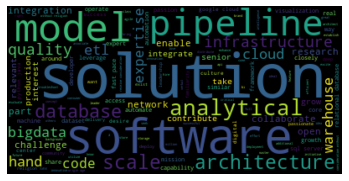

solution          2543
sql               1933
pipeline          1911
database          1775
cloud             1701
model             1624
python            1574
software          1552
aws               1308
warehouse         1280
architecture      1149
spark             1041
etl               1036
bigdata           1032
quality            998
infrastructure     950
analytical         941
scale              736
stream             736
code               722
dtype: int64


Data Scientist


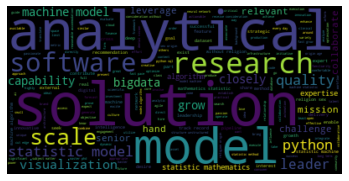

model            7871
statistic        5891
machine          5127
solution         3787
analytical       3469
research         3179
python           2830
algorithm        2138
r                2012
sql              1981
software         1924
method           1550
deep             1522
visualization    1458
ai               1441
mathematics      1369
expertise        1358
challenge        1242
grow             1205
mine             1154
dtype: int64


Business Analyst


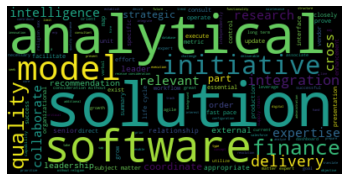

solution        4080
analytical      2939
software        1736
quality         1111
model           1046
sql             1023
agile            890
excel            834
initiative       833
finance          805
microsoft        758
senior           735
strategic        719
delivery         692
integration      691
coordinate       684
goal             682
relationship     677
story            669
cross            665
dtype: int64


Analyst


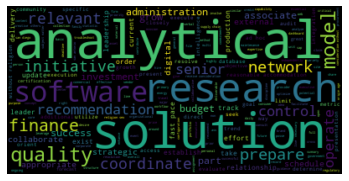

analytical    1518
solution      1230
research       830
model          803
software       707
quality        614
finance        512
excel          470
microsoft      454
statistic      438
sql            432
network        425
day            420
full           415
control        410
also           409
part           404
budget         398
insurance      398
origin         395
dtype: int64


Data Analyst


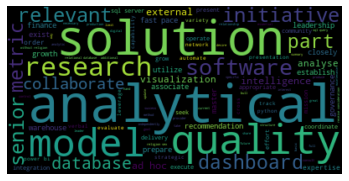

analytical       4363
sql              2822
solution         2811
quality          2764
database         2440
statistic        2425
model            2172
research         1669
software         1468
excel            1424
visualization    1134
microsoft        1121
query            1088
tableau          1011
dashboard         998
senior            941
master            932
python            929
trend             924
full              918
dtype: int64


[solution          2543
sql               1933
pipeline          1911
database          1775
cloud             1701
model             1624
python            1574
software          1552
aws               1308
warehouse         1280
architecture      1149
spark             1041
etl               1036
bigdata           1032
quality            998
infrastructure     950
analytical         941
scale              736
stream             736
code               722
azure              713
integration        699
machine            644
hadoop         

In [32]:
from wordcloud import WordCloud
#collocations=False
# jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'AI',
#  'Data Analyst', 'Intern', 'Consultant', 'Business Intelligence', 'Sales',
#  'Workforce Analyst' ,'Cyber Security' ,'Researcher', 'Scientist',
#  'Data Modeler', 'Data Architect', 'Research Scientist',
#  'Machine Learning Scientist', 'Developer', 'Applied Scientist',
#  'Machine Learning Engineer', 'Big Data', 'Environmental Scientist',
#  'AI Engineer', 'Clinical Scientist', 'Computer Scientist', 'Engineer',
#  'Medical Scientist', 'Product Manager', 'Systems Engineer',
#  'Research Engineer', 'Machine Learning', 'Software Engineer',
#  'Applications Engineer', 'Cloud Engineer', 'Full Stack Engineer']

filterList=[]
def fun(x):
    
    if x is None:
        return ""
    wordList.append(x)
    
jt=['Data Engineer', 'Data Scientist', 'Business Analyst', 'Analyst', 'Data Analyst']

for job in jt:
    wordList=[]
    FDSword.loc[FDSword['edit_jobTitle']==job]['edit_jobDescription'].dropna().apply(lambda x: fun(x))   
    abc=" ".join(wordList)
    wordcloud = WordCloud().generate(abc)
    # Display the generated image:      
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(job)
    plt.show()
    words=pd.Series(abc.split())
    print(words.value_counts().sort_values(ascending=False).head(20))
    filterList.append(words.value_counts().sort_values(ascending=False).head(25))
    
    print("\n")

print(filterList)
    

In [22]:
def remote(x):
    x=x.lower()
    if "remote" in x:
        r=1
    else:
        r=0
    return r

def part(x):
    x=x.lower()
    if "part-time" in x or "part time" in x:
        r=1
    else:
        r=0
    return r

def temp(x):
    x=x.lower()
    if "temp" in x:
        r=1
    else:
        r=0
    return r

def senior(x):
    x=x.lower()
    if "senior" in x or "sr" in x:
        r=1
    else:
        r=np.nan
    return r

def sen2(x):
    if x!=np.nan:
        s=x
    else:
        s=np.nan
        

#Senior = x[16]
#sen= x[23]
FullDataSet['remote']=FullDataSet['Job Description'].dropna().apply(lambda x: remote(x))
FullDataSet['part-time']=FullDataSet['Job Description'].dropna().apply(lambda x: part(x))
FullDataSet['temp']=FullDataSet['Job Description'].dropna().apply(lambda x: temp(x))
FullDataSet['sen']=FullDataSet['Job Description'].dropna().apply(lambda x: senior(x))
FullDataSet['Senior'].fillna(FullDataSet['sen'], inplace=True)


In [23]:
print(FullDataSet['remote'].sum())
print(FullDataSet['part-time'].sum())
print(FullDataSet['temp'].sum())

1299.0
252.0
1042.0


In [24]:
FullDataSet[FullDataSet['sen']==1]

Job Title  \
8659                       Investment Analyst - Graduate   
8660                        IT Business Process Analysis   
8663   PGIM Investments - Research Analyst, Strategic...   
8668                                     Digital Analyst   
8669               Municipal Structured Products Analyst   
...                                                  ...   
27035     MACHINE LEARNING ENGINEER / Sr. DATA SCIENTIST   
27036           Data Modeler/Data Scientist (Instructor)   
27038  Research Scientist (Machine Learning and Artif...   
27042                  Data Scientist with Active Secret   
27044                  Data Scientist - TS/SCI with Poly   

                                         Job Description  \
8659   About Swiss Re\n\nThe Swiss Re Group is one of...   
8660   Bristol-Myers Squibb is a global Biopharma com...   
8663   The Strategic Investment Research Group (SIRG)...   
8668   Digital Analyst\n\nHackensack, NJ\n\nAt Upfiel...   
8669   The Company\n\nMesirow Financial is an indepen...   
...                                                  ...   
27035  Title: MACHINE LEARNING ENGINEER / Sr. DATA SC...   
27036  Title: Data Modeler/Data Scientist\n\nLocation...   
27038  Title: Research Scientist (Machine Learning an...   
27042  Responsibilities include:\n- Support a team of...   
27044  Data Scientist - TS/SCI with Poly\nClearance L...   

                      Company Name           Location           City State  \
8659                      Swiss Re       New York, NY       New York    NY   
8660          Bristol-Myers Squibb    Jersey City, NJ    Jersey City    NJ   
8663                          PGIM         Newark, NJ         Newark    NJ   
8668                       Upfield     Hackensack, NJ     Hackensack    NJ   
8669             Mesirow Financial       New York, NY       New York    NY   
...                            ...                ...            ...   ...   
27035     Samsung Research America  Mountain View, CA  Mountain View    CA   
27036             Royce Geospatial    Springfield, VA    Springfield    VA   
27038     Samsung Research America  Mountain View, CA  Mountain View    CA   
27042  Maania Consultancy Services         Dulles, VA         Dulles    VA   
27044                     Coverent         McLean, VA         McLean    VA   

          Remote          Size  Founded                             Industry  \
8659   Uncertain    Very Large   1863.0        Insurance Agencies Brokerages   
8660   Uncertain    Very Large   1858.0              Biotech Pharmaceuticals   
8663   Uncertain  Medium-Large      NaN  Investment Banking Asset Management   
8668   Uncertain  Medium-Large   1871.0          Food Beverage Manufacturing   
8669   Uncertain        Medium   1937.0  Investment Banking Asset Management   
...          ...           ...      ...                                  ...   
27035  Uncertain  Medium-Large   1988.0         Computer Hardware & Software   
27036  Uncertain         Small   2014.0                  Aerospace & Defense   
27038  Uncertain  Medium-Large   1988.0         Computer Hardware & Software   
27042  Uncertain    Very Small      NaN                                  NaN   
27044  Uncertain         Small   2008.0                           Consulting   

       ...  Hourly  Junior  Senior   DF  \
8659   ...   False     NaN     1.0  DF1   
8660   ...   False     NaN     1.0  DF1   
8663   ...   False     NaN     1.0  DF1   
8668   ...   False     NaN     1.0  DF1   
8669   ...   False     NaN     1.0  DF1   
...    ...     ...     ...     ...  ...   
27035  ...   False     NaN     1.0   DS   
27036  ...   False     NaN     1.0   DS   
27038  ...   False     NaN     1.0   DS   
27042  ...   False     NaN     1.0   DS   
27044  ...   False     NaN     1.0   DS   

                                     edit_jobDescription  \
8659   swiss swiss group         provider reinsurance...   
8660   bristol myers squibb global biopharma   commit...   
8663   str

In [25]:
cities=pd.DataFrame(FullDataSet['City'].value_counts())
cities.head(50)

City
New York            1780
San Diego            871
Austin               806
Chicago              794
Houston              706
San Antonio          631
Seattle              626
Los Angeles          525
San Francisco        491
Philadelphia         475
Dallas               426
Phoenix              422
San Jose             298
Denver               247
Jacksonville         217
Sunnyvale            201
Irving               198
Salt Lake City       188
Santa Clara          176
Columbus             171
New York City        160
Tempe                148
Mountain View        143
Plano                142
Fort Worth           131
Redmond              115
Menlo Park           115
Palo Alto             98
Bellevue              95
Boulder               90
Scottsdale            89
Charlotte             84
Redwood City          84
Tampa                 84
Burbank               81
Wilmington            73
El Segundo            70
Lehi                  69
Orlando               64
Jersey City           58
Santa Monica          58
Miami                 56
San Mateo             53
Arlington             51
Chandler              51
Glendale              50
Brooklyn              49
Santa Clara Valley    48
Cambridge             48
Fremont               47

In [26]:
tables= pd.read_html('https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020&region=021', header=0)
cost_living=tables[1]
def splitter(x, i):
    return x.split(',')[i]
cost_living=cost_living[cost_living.City.str.contains("United States")] 
cost_living.reset_index(drop=True, inplace=True)
cost_living["Rank"]=cost_living.index+1
cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
cost_living["Country"]=cost_living.City.apply(lambda x: splitter(x,2))
cost_living["City"]=cost_living.City.apply(lambda x: splitter(x,0))
cost_living.count()
cost_living

<ipython-input-26-680448283021>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["Rank"]=cost_living.index+1
<ipython-input-26-680448283021>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_living["State"]=cost_living.City.apply(lambda x: splitter(x,1))
<ipython-input-26-680448283021>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Rank              City  Cost of Living Index  Rent Index  \
0      1          New York                100.00      100.00   
1      2     San Francisco                 91.51      115.58   
2      3         Anchorage                 91.36       38.94   
3      4          Honolulu                 89.70       63.03   
4      5          Brooklyn                 88.82       80.49   
5      6        Washington                 87.74       78.18   
6      7           Oakland                 86.51       79.55   
7      8           Seattle                 85.77       65.70   
8      9            Boston                 82.88       74.47   
9     10          Bellevue                 82.18       63.24   
10    11           Chicago                 80.18       58.64   
11    12          Sarasota                 79.26       46.44   
12    13      Philadelphia                 78.84       46.87   
13    14          San Jose                 78.64       83.34   
14    15          Portland                 78.63       49.42   
15    16       New Orleans                 78.46       41.29   
16    17        Sacramento                 77.00       46.21   
17    18       Minneapolis                 76.70       45.26   
18    19       Los Angeles                 76.55       72.90   
19    20            Albany                 75.44       33.00   
20    21      Jacksonville                 74.57       33.58   
21    22         Baltimore                 74.29       42.61   
22    23         San Diego                 74.22       66.83   
23    24             Miami                 74.16       57.56   
24    25           Buffalo                 73.92       28.28   
25    26           Atlanta                 73.89       46.82   
26    27              Reno                 73.85       38.22   
27    28        Pittsburgh                 73.61       35.86   
28    29            Denver                 73.30       51.98   
29    30         Nashville                 73.19       46.76   
30    31         Charlotte                 72.40       42.37   
31    32            Tucson                 72.12       26.44   
32    33           Olympia                 71.88       41.28   
33    34  Colorado Springs                 70.97       36.00   
34    35            Tacoma                 70.88       41.20   
35    36       Saint Louis                 70.78       28.97   
36    37          Columbus                 70.50       31.39   
37    38           Raleigh                 69.80       36.60   
38    39       Kansas City                 69.17       30.51   
39    40            Dallas                 68.03       47.05   
40    41            Austin                 67.79       52.04   
41    42         Las Vegas                 67.46       36.26   
42    43           Phoenix                 67.41       36.18   
43    44          Richmond                 67.20       33.88   
44    45             Tampa                 67.10       40.83   
45    46        Louisville                 66.72       28.71   
46    47      Indianapolis                 66.34       29.25   
47    48       San Antonio                 65.78       36.50   
48    49           Orlando                 65.70       41.51   
49    50           Houston                 65.13       42.70   
50    51    Salt Lake City                 64.76       36.83   
51    52           Madison                 64.67       38.11   
52    53             Tulsa                 64.28       26.38   
53    54           Detroit                 63.85       37.80   
54    55        Cincinnati                 61.64       33.99   
55    56             Boise                 60.71       34.47   
56    57       Little Rock                 59.76       26.39   
57    58           El Paso                 52.38       22.71   

    Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                           100.00           100.00                  100.00   
1                           103.02            86.91                  